In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import utils

# 数据集路径
IMAGE_DIR = "data/nih/images-small/"
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")
test_df = pd.read_csv("data/nih/test.csv")

# 类别标签
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 
          'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 
          'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']


In [2]:
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_dir, labels, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 加载图像
        img_path = f"{self.image_dir}/{self.dataframe.iloc[idx]['Image']}"
        image = Image.open(img_path).convert('RGB')
        
        # 加载标签
        label = self.dataframe.iloc[idx][self.labels].values.astype(float)
        
        # 应用变换
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float)


In [3]:
# 数据增强和归一化
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 创建数据集
train_dataset = ChestXRayDataset(train_df, IMAGE_DIR, labels, transform)
valid_dataset = ChestXRayDataset(valid_df, IMAGE_DIR, labels, transform)
test_dataset = ChestXRayDataset(test_df, IMAGE_DIR, labels, transform)

# 数据加载器
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    if patients_in_both_groups:
        leakage = True # boolean (true if there is at least 1 patient in both groups)
    else:
        leakage = False
    
    ### END CODE HERE ###
    
    return leakage

In [5]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [6]:
train_loader

In [7]:
# 计算训练集中每个类别的频率
all_labels = []

for _, label in train_loader:
    all_labels.append(label)

# 合并所有批次的标签
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# 计算每个类别的平均值
class_frequencies = np.mean(all_labels, axis=0)

class_frequencies.astype(np.float32)

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033], dtype=float32)

In [8]:
labels

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

In [9]:
freq_pos = class_frequencies
freq_neg = 1 - class_frequencies
freq_pos = freq_pos.astype(np.float32)
freq_neg = freq_neg.astype(np.float32)

In [10]:
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033], dtype=float32)

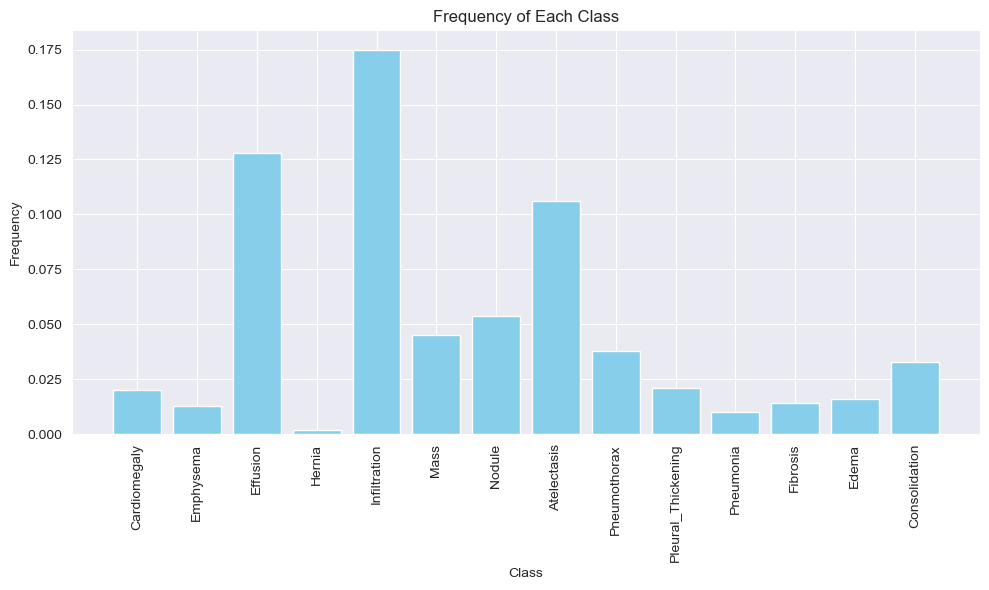

In [11]:
# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(x=labels, height=class_frequencies.ravel(), color='skyblue')
plt.xticks(rotation=90)
plt.title("Frequency of Each Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


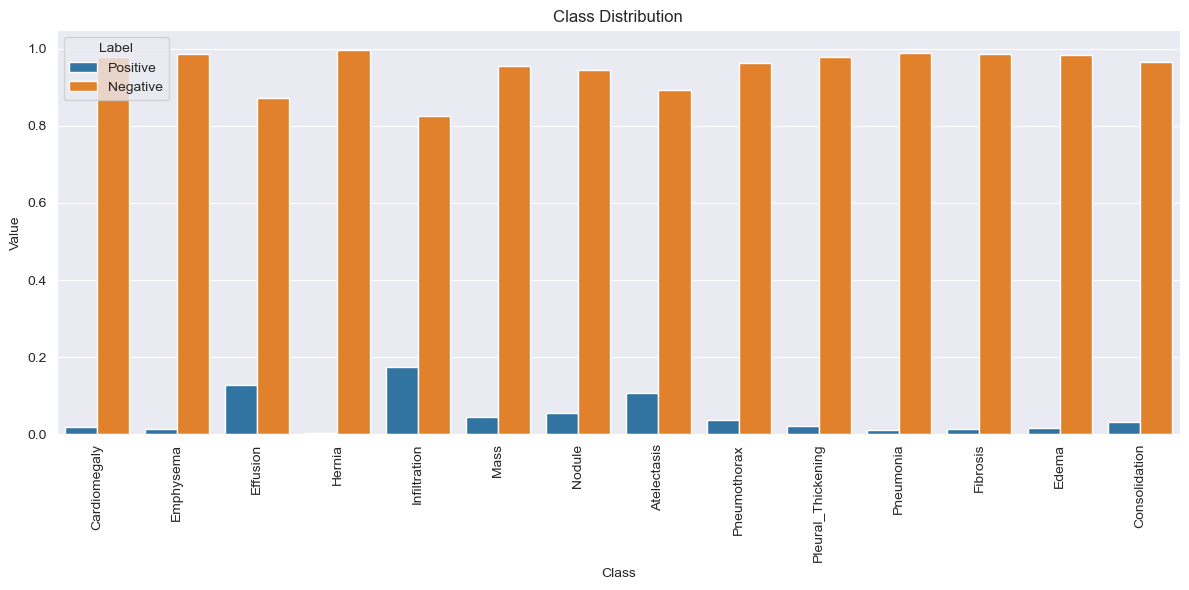

In [12]:
# data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
# data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
# plt.xticks(rotation=90)
# f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)
# 创建 DataFrame
data_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data_neg = pd.DataFrame({"Class": labels, "Label": "Negative", "Value": freq_neg})
# 合并数据
data = pd.concat([data_pos, data_neg], ignore_index=True)
# 绘制柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

In [13]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

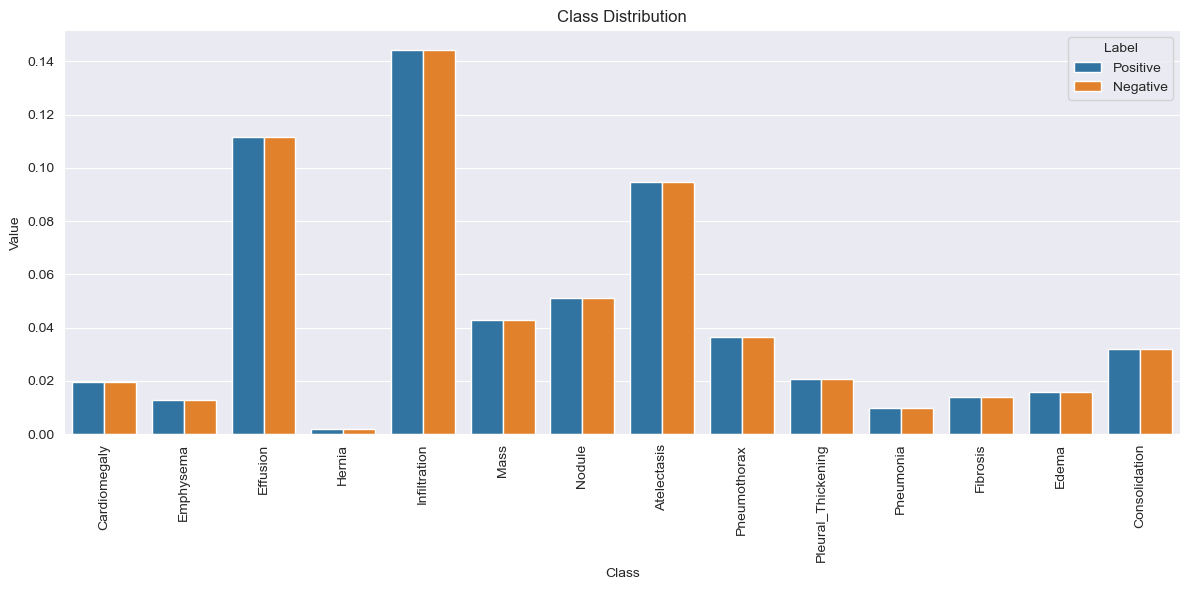

In [14]:
data_contribution_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data_contribution_neg = pd.DataFrame({"Class": labels, "Label": "Negative", "Value": neg_contribution})
data_contribution = pd.concat([data_contribution_pos, data_contribution_neg], ignore_index=True)
# 绘制柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Value", hue="Label", data=data_contribution)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

In [15]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_pred, y_true):
        loss = 0.0
        for i in range(len(pos_weights)):
            loss += torch.mean(
                -pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon) -
                neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon)
            )
        return loss
    return weighted_loss


In [16]:
# 加载预训练模型
model = models.densenet121(weights='IMAGENET1K_V1')

In [17]:
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [24]:
len(labels)

14

In [18]:
# 替换最后一层，加入平均池化层
num_ftrs = model.classifier.in_features

model.classifier = nn.Sequential(
    # nn.AdaptiveAvgPool1d(1),  # 添加平均池化层
    # nn.Flatten(),             # 展平成 (batch_size, num_features)
    nn.Linear(num_ftrs, len(labels)),  # 全连接层
    nn.Sigmoid()              # Sigmoid 激活
)

model = model.cuda()  # 将模型移动到 GPU（如果可用）

In [19]:
def compute_class_freqs(labels):
    N = labels.shape[0]
    pos_frequencies = np.sum(labels, axis=0) / N
    neg_frequencies = 1 - pos_frequencies
    return pos_frequencies, neg_frequencies

# 计算权重
freq_pos, freq_neg = compute_class_freqs(train_df[labels].values)
print(freq_pos)
pos_weights = torch.tensor(freq_neg, dtype=torch.float).cuda()
neg_weights = torch.tensor(freq_pos, dtype=torch.float).cuda()

# 初始化损失函数
criterion = get_weighted_loss(pos_weights, neg_weights)


[0.02  0.013 0.128 0.002 0.175 0.045 0.054 0.106 0.038 0.021 0.01  0.014
 0.016 0.033]


In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [21]:
from d2l import torch as d2l

devices = d2l.try_all_gpus()

In [25]:
num_epochs = 5
# d2l.train_ch13(model, train_loader, test_loader, criterion, optimizer, num_epochs, devices)

# 训练函数
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# 训练模型
train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 0.8036719291210175
Epoch 2, Loss: 0.6482868518829346
Epoch 3, Loss: 0.5255782580375672
Epoch 4, Loss: 0.40581154835224154
Epoch 5, Loss: 0.297230938911438


In [ ]:
# 将模型设置为评估模式
model.eval()

predicted_vals = []

# 禁用梯度计算（节省内存，避免反向传播）
with torch.no_grad():
    for data, _ in test_loader:  # 假设 test_generator 返回 (inputs, labels) 形式
        data = data.cuda()  # 如果模型在 GPU 上，移动数据到 GPU
        outputs = model(data)  # 获取模型的输出
        predicted_vals.append(outputs.cpu())  # 收集预测值并移回 CPU

# 将所有批次的预测值拼接起来
predicted_vals = torch.cat(predicted_vals, dim=0)

In [23]:
for name, param in model.state_dict().items():
    print(f"Layer: {name} | Size: {param.size()}")

Layer: features.conv0.weight | Size: torch.Size([64, 3, 7, 7])
Layer: features.norm0.weight | Size: torch.Size([64])
Layer: features.norm0.bias | Size: torch.Size([64])
Layer: features.norm0.running_mean | Size: torch.Size([64])
Layer: features.norm0.running_var | Size: torch.Size([64])
Layer: features.norm0.num_batches_tracked | Size: torch.Size([])
Layer: features.denseblock1.denselayer1.norm1.weight | Size: torch.Size([64])
Layer: features.denseblock1.denselayer1.norm1.bias | Size: torch.Size([64])
Layer: features.denseblock1.denselayer1.norm1.running_mean | Size: torch.Size([64])
Layer: features.denseblock1.denselayer1.norm1.running_var | Size: torch.Size([64])
Layer: features.denseblock1.denselayer1.norm1.num_batches_tracked | Size: torch.Size([])
Layer: features.denseblock1.denselayer1.conv1.weight | Size: torch.Size([128, 64, 1, 1])
Layer: features.denseblock1.denselayer1.norm2.weight | Size: torch.Size([128])
Layer: features.denseblock1.denselayer1.norm2.bias | Size: torch.Size

In [30]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda()
            preds = model(images)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
    
    return np.concatenate(all_preds), np.concatenate(all_labels)

# 计算 AUC
preds, pre_labels = evaluate_model(model, test_loader)
auc_scores = [roc_auc_score(pre_labels[:, i], preds[:, i]) for i in range(len(pre_labels[0]))]



In [31]:
auc_scores

[0.40362162162162163,
 0.6596840659340659,
 0.708960978869981,
 0.5582702702702702,
 0.5662237663740082,
 0.5797222222222221,
 0.4430783242258652,
 0.7075462962962963,
 0.6643088418430885,
 0.6218327300438179,
 0.5983783783783783,
 0.6023562719758893,
 0.8208108108108109,
 0.6253148938357925]

In [32]:
pre_labels

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 
          'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 
          'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

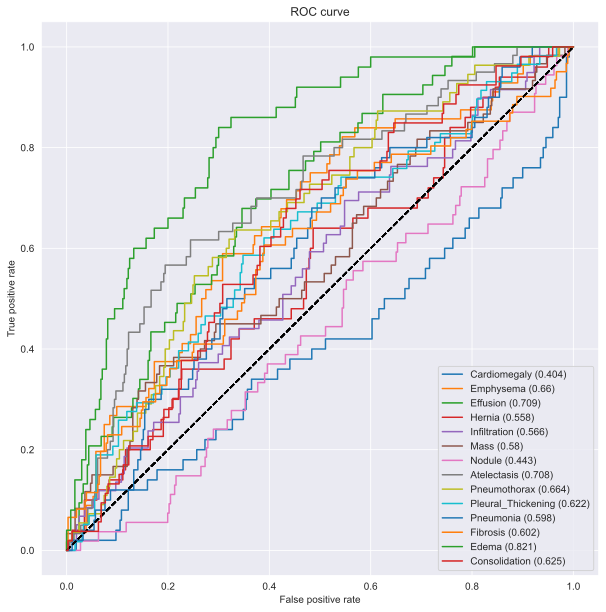

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(pre_labels, predicted_vals,labels):
    auc_roc_vals = []
    for i in range(len(pre_labels[0])):
        try:
            gt = pre_labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

auc_scores_curve = get_roc_curve(pre_labels, preds,labels)

In [35]:
# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_scores_curve)[::-1])[:4]

In [36]:
utils.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, train_df, labels, labels_to_show)

TypeError: Unexpected type <class 'NoneType'>